In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("sp500.csv")
#print(df.head())
# Make single variable
#df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index(['Date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]



In [4]:
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(4227, 5)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
    
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
# Process the data for the shape of the moving window
def ExtractFeatures(sequence, n_steps, window_space=1):
    
    for j in range(sequence.shape[1]):
        mean_seq = []
        variance_seq = []
        skewness_seq = []
        sum_seq = []
        min_seq = []
        max_seq = []
        range_seq = []
        median_seq = []
        iqr_seq = []
        stochastic_oscillator = []
        
        label_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > len(sequence)-1:
                break
            data = sequence[i:end_index, j]
            
            #Average of window
            mean = np.mean(data)
            mean_seq.append(mean)
            #Varience of window
            #variance = np.var(data)
            #variance_seq.append(variance)
            #Skewness of window
            #skewness_seq.append(float(skew(data)))
            #Sum of window
            #Sum = np.sum(data)
            #sum_seq.append(Sum)
            #Min of window
            Min = np.min(data)
            min_seq.append(Min)
            #Max of window
            Max = np.max(data)
            max_seq.append(Max)
            #Range of window
            Range = Max-Min
            range_seq.append(Range)
            #Median of window
            median = np.median(data)
            median_seq.append(median)
            #IQR of window
            iqr = np.subtract(*np.percentile(data, [75, 25]))
            iqr_seq.append(iqr)
            #Stochastic oscillator
            #so = ((data[-1]-Min)/(Range))
            #stochastic_oscillator.append(so)
        
        mean_seq = np.array(mean_seq)
        #variance_seq = np.array(variance_seq)
        #skewness_seq = np.array(skewness_seq)
        #sum_seq = np.array(sum_seq)
        min_seq = np.array(min_seq)
        max_seq = np.array(max_seq)
        range_seq = np.array(range_seq)
        median_seq = np.array(median_seq)
        iqr_seq = np.array(iqr_seq)
        #stochastic_oscillator = np.array(stochastic_oscillator)

        
        mean_seq = mean_seq.reshape(len(mean_seq),1)
        #variance_seq = variance_seq.reshape(len(variance_seq),1)
        #skewness_seq = skewness_seq.reshape(len(skewness_seq),1)
        #sum_seq = sum_seq.reshape(len(sum_seq),1)
        min_seq = min_seq.reshape(len(min_seq),1)
        max_seq = max_seq.reshape(len(max_seq),1)
        range_seq = range_seq.reshape(len(range_seq),1)
        median_seq = median_seq.reshape(len(median_seq),1)
        iqr_seq = iqr_seq.reshape(len(iqr_seq),1)
        #stochastic_oscillator = stochastic_oscillator.reshape(len(stochastic_oscillator),1)
        
        if j == 0:
            features = np.hstack((mean_seq, iqr_seq, median_seq)) 
            
        else:
            features = np.hstack((features, mean_seq, iqr_seq, median_seq)) 
            
    return (features)

In [7]:
def FullyConnected(hiddensize, num_layers):
    
    fullyconnected = Sequential()
    fullyconnected.add(Dense(hiddensize, input_shape=(None, train_input.shape[2]), activation='relu'))
    
    for i in range(num_layers-1):
        fullyconnected.add(Dense(hiddensize//2, activation='relu'))
        
    fullyconnected.add(Dense(1, activation='linear'))
    fullyconnected.build()
    return fullyconnected

In [8]:
#Hyper-Parameters
window_size = 2
window_space = 1
FF_size = 1500
FF_layers = 2
learning_rate = 0.001
epochs = 30
batch_size = 32

#Extract train and test features
train_features = ExtractFeatures(x_train_scaled, window_size, window_space)
test_features = ExtractFeatures(x_test_scaled, window_size, window_space)
train_input, test_input = np.expand_dims(train_features, axis=1), np.expand_dims(test_features, axis=1)

#Get train and test labels
train_labels = GetLabels(y_train_scaled, window_size, window_space)
test_labels = GetLabels(y_test_scaled, window_size, window_space)

#train_labels, test_labels = train_labels.reshape(len(train_labels)), test_labels.reshape(len(test_labels))

#Validation Data
validation_data = (test_input, test_labels)

print(train_input.shape)
print(train_labels.shape)
print(test_input.shape)
print(test_labels.shape)


(4225, 1, 15)
(4225, 1)
(468, 1, 15)
(468, 1)


In [9]:
#Principle Component Analysis
sk_model = PCA(n_components=train_input.shape[1])
sk_model.fit_transform(train_features)
print(sk_model.explained_variance_ratio_)

[0.91878221]


In [10]:
def split_sequence(sequence, n_steps, window_space=1):
    data_seq = []
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        x, y = sequence[i:end_index, :-1], sequence[i:end_index, -1]
        data_seq.append(x) 
        label_seq.append(y)
        
    data_seq, label_seq = np.array(data_seq), np.array(label_seq)
    if (n_steps > 1):
        label_seq = np.expand_dims(label_seq, axis=2)
    return (data_seq, label_seq)

In [11]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)

model = FullyConnected(FF_size, FF_layers)

model.compile(loss=mse, 
              optimizer=optimiser,
              metrics=['MAE'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 1500)        24000     
_________________________________________________________________
dense_1 (Dense)              (None, None, 750)         1125750   
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           751       
Total params: 1,150,501
Trainable params: 1,150,501
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_input,
                    train_labels,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=validation_data,
                    shuffle=False)

Train on 4225 samples, validate on 468 samples
Epoch 1/30
4225/4225 [==============================] - 1s 168us/sample - loss: 0.1805 - mean_absolute_error: 0.3819 - val_loss: 0.9676 - val_mean_absolute_error: 0.9741
Epoch 2/30
4225/4225 [==============================] - 0s 96us/sample - loss: 0.1449 - mean_absolute_error: 0.3409 - val_loss: 0.7994 - val_mean_absolute_error: 0.8837
Epoch 3/30
4225/4225 [==============================] - 0s 94us/sample - loss: 0.1175 - mean_absolute_error: 0.3058 - val_loss: 0.6652 - val_mean_absolute_error: 0.8037
Epoch 4/30
4225/4225 [==============================] - 0s 95us/sample - loss: 0.0956 - mean_absolute_error: 0.2748 - val_loss: 0.5550 - val_mean_absolute_error: 0.7315
Epoch 5/30
4225/4225 [==============================] - 0s 95us/sample - loss: 0.0776 - mean_absolute_error: 0.2466 - val_loss: 0.4624 - val_mean_absolute_error: 0.6656
Epoch 6/30
4225/4225 [==============================] - 0s 96us/sample - loss: 0.0625 - mean_absolute_error

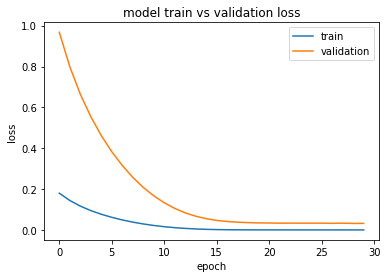

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

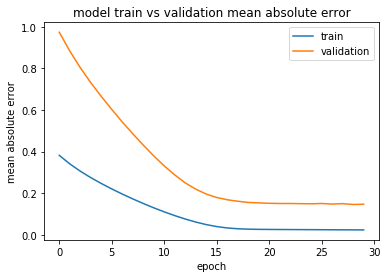

In [14]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
results = model.evaluate(x = test_input,
                        y = test_labels)
print('loss(test-set):', results)

468/468 [==============================] - 0s 64us/sample - loss: 0.0037 - mean_absolute_error: 0.0518
loss(test-set): [0.0036895728001418784, 0.051802896]


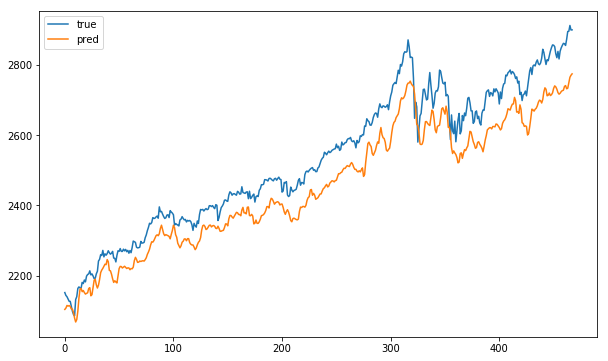

In [16]:
def plot_comparison():
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """

       # Use test-data.
    x = test_input
    y_true = y_scaler.inverse_transform(test_labels)
    
    #x = np.expand_dims(x, axis=1)
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    # Input-signals for the model.
    
    
    # Use the model to predict the output-signals.
    x_pred = model.predict(x)    

    x_pred = x_pred.reshape(-1,1)

    y_pred_rescaled = y_scaler.inverse_transform(x_pred)
    
    # For each output-signal.
    

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    
plot_comparison()